# Analyzing Performance at the 2025 SF Marathon: Terrain, Pace, and Heart Rate

This notebook explores my performance at the 2025 San Francisco Marathon. The data is pulled from Strava records of my 26.2-mile race. The focus of this exploratory analysis is to identify the relationship between course structure and terrain (elevation, distance segments, and aid stations) on performance metrics such as pace and heartrate. The goal is to draw insights to guide future training and serve as a reference if I run this marathon agian. 

The analysis is done using SQL and Python (pandas, matplotlib) in a Jupyter notebook. Raw data (TCX and GPX) was cleaned in separate Python scripts. 

## 1. Overview of the Data 

In [ ]:
# Data, SQL, visualization imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import plotly.express as px
import plotly.graph_objects as go


                  name
0             tcx_data
1  official_route_data
2    aid_stations_data


In [ ]:
# Connect to SQLite database 
con = sqlite3.connect("../data/marathon_data.db") 
cur = con.cursor()
    
# Verify tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)
print(tables)

In [49]:
# Show all columns in each table
tcx_cols = pd.read_sql("PRAGMA table_info(tcx_data);", con)
print("TCX Data Columns:")
print(tcx_cols[['name', 'type']])

official_route_cols = pd.read_sql("PRAGMA table_info(official_route_data);", con)
print("Official Route Data Columns:")
print(official_route_cols[['name', 'type']])

aid_stations_cols = pd.read_sql("PRAGMA table_info(aid_stations_data);", con)
print("Aid Stations Data Columns:")
print(aid_stations_cols[['name', 'type']])


TCX Data Columns:
         name     type
0        time     TEXT
1    latitude     REAL
2   longitude     REAL
3   elevation     REAL
4    distance     REAL
5  heart_rate  INTEGER
Official Route Data Columns:
        name  type
0   latitude  REAL
1  longitude  REAL
2  elevation  REAL
Aid Stations Data Columns:
        name  type
0       name  TEXT
1   latitude  REAL
2  longitude  REAL
3       type  TEXT


The database contains three tables: `tcx_data`, `official_route_data`, and `aid_stations_data`. The names and data types of the columns in each are as follows:

- `tcx_data`: data from my race recorded on my Apple Watch
    - __time__: timestamp in UTC for each row entry; TEXT (convertible to date-time)
    - __latitude__: GPS latitude in decimal degrees (WGS84 coordinate system); REAL
    - __longitude__: GPS longitude in decimal degrees (WGS84 coordinate system); REAL
    - __elevation__: altitude above sea level, in meters; REAL
    - __distance__: cumulative distance covered since the start, in meters; REAL
    - __heart_rate__: runner’s heart rate at that moment, in beats per minute (BPM); INTEGER

- `official_route_data`: official route data provided by SFM organizers
    - __latitude__: GPS latitude in decimal degrees (WGS84 coordinate system); REAL
    - __longitude__: GPS longitude in decimal degrees (WGS84 coordinate system); REAL
    - __elevation__: altitude above sea level, in meters; REAL

- `aid_stations_data`: official route data provided by SFM organizers
    - __name__: name of the waypoint; TEXT
    - __latitude__: GPS latitude in decimal degrees (WGS84 coordinate system); REAL
    - __longitude__: GPS longitude in decimal degrees (WGS84 coordinate system); REAL
    - __type__: type of the waypoint; TEXT

The following cell shows the first 5 rows of each table. 

In [50]:
print("=== TCX Data (First 5 Rows) ===")
tcx_sample = pd.read_sql("SELECT * FROM tcx_data LIMIT 5;", con)
display(tcx_sample)

print("\n=== Official Route Data (First 5 Rows) ===")
route_sample = pd.read_sql("SELECT * FROM official_route_data LIMIT 5;", con)
display(route_sample)

print("\n=== Aid Stations Data (First 5 Rows) ===")
aid_sample = pd.read_sql("SELECT * FROM aid_stations_data LIMIT 5;", con)
display(aid_sample)

=== TCX Data (First 5 Rows) ===


,time,latitude,longitude,elevation,distance,heart_rate
0,2025-07-27 12:35:21,37.794481,-122.394033,6.2,0.0,116
1,2025-07-27 12:35:22,37.794512,-122.394049,6.0,1.4,116
2,2025-07-27 12:35:23,37.794526,-122.394061,6.0,2.8,116
3,2025-07-27 12:35:24,37.794539,-122.394074,6.4,4.1,116
4,2025-07-27 12:35:25,37.794552,-122.394086,6.4,5.5,116



=== Official Route Data (First 5 Rows) ===


,latitude,longitude,elevation
0,37.795170,-122.393770,3.74
1,37.795280,-122.393860,3.74
2,37.795340,-122.393780,3.33
3,37.795945,-122.394335,3.21
4,37.796550,-122.394890,3.12



=== Aid Stations Data (First 5 Rows) ===


,name,latitude,longitude,type
0,Water Stop/Aid Station,37.80709,-122.42587,Aid Station
1,Water Stop/Aid Station,37.80618,-122.46882,Aid Station
2,Water Stop/Aid Station,37.83240,-122.47991,Aid Station
3,Water Stop/Aid Station,37.83621,-122.47356,Aid Station
4,Water Stop/Aid Station,37.83245,-122.48180,Aid Station


## 2. Data cleaning and processing

Before performing any analysis, the raw data is inspected for anomalies to ensure accurate results. 

- **Distance units:** Original distance values were in meters; they are converted to kilometers for readability.
- **Pace calculation:** Pace was computed in a SQL view prior to loading into a pandas dataframe for efficiency.
- **Route validation:** To confirm data quality, the elevation profile is compared against the official course route published by the organizers on Strava. This ensures the cleaned data aligns with the actual course.
- **Distance calculation for the official course data:** The original data only contains coordinates and elevation; distance in km was calculated in Python to allow smoother comparison with my data. 
- **Elevation spikes:** One elevation measurement (~250 m) was clearly outside the plausible range for the course. This was replaced using linear interpolation to preserve continuity.


In [ ]:
# Create a view for processed tcx race data with pace and distance in km
race_query = """
CREATE VIEW IF NOT EXISTS processed_view AS
SELECT
    time,
    latitude,
    longitude,
    elevation,
    distance / 1000.0 AS distance_km,
    heart_rate,
    -- compute delta time (sec)
    CAST(
        (strftime('%s', time) - strftime('%s', LAG(time) OVER (ORDER BY time)))
        AS REAL
    ) AS delta_time,
    -- compute delta distance (m)
    (distance - LAG(distance) OVER (ORDER BY time)) AS delta_dist,
    -- compute pace (min/km)
    CAST(
        (strftime('%s', time) - strftime('%s', LAG(time) OVER (ORDER BY time))) / 60.0 /
        NULLIF((distance - LAG(distance) OVER (ORDER BY time)) / 1000.0, 0)
        AS REAL
    ) AS pace
FROM tcx_data
"""

cur.execute(race_query)
con.commit()

# Load view to pandas dataframe
tcx_df = pd.read_sql("SELECT * FROM processed_view;", con)

In [ ]:
# Query official route data
official_route_query = """
SELECT
    latitude,
    longitude,
    elevation
FROM official_route_data
"""

cur.execute(official_route_query)
con.commit()

# Create a dataframe to store official route data with segment distance and distance from start in km
official_route_df = pd.read_sql("SELECT * FROM official_route_data;", con)

distances = [0.0]
for i in range(1, len(official_route_df)):
    start = (official_route_df.iloc[i-1]['latitude'], official_route_df.iloc[i-1]['longitude'])
    end = (official_route_df.iloc[i]['latitude'], official_route_df.iloc[i]['longitude'])
    distances.append(geodesic(start, end).km)

official_route_df['segment_distance'] = distances
official_route_df['cumulative_distance_km'] = official_route_df['segment_distance'].cumsum()


,latitude,longitude,elevation,segment_distance,cumulative_distance_km
0,37.795170,-122.393770,3.74,0.000000,0.000000
1,37.795280,-122.393860,3.74,0.014557,0.014557
2,37.795340,-122.393780,3.33,0.009695,0.024252
3,37.795945,-122.394335,3.21,0.083058,0.107310
4,37.796550,-122.394890,3.12,0.083058,0.190368


In [58]:
# Plot to compare recorded data to official route
fig = go.Figure()

# Elevation from race data
fig.add_trace(go.Scatter(
    x=tcx_df['distance_km'],
    y=tcx_df['elevation'],
    mode='lines',
    name='My Race Elevation',
    line=dict(color='blue', width=2),
    opacity=0.7,
    hovertemplate='Distance: %{x:.2f} km<br>My Elevation: %{y:.1f} m<extra></extra>'
))

# Official route elevation
fig.add_trace(go.Scatter(
    x=official_route_df['cumulative_distance_km'],
    y=official_route_df['elevation'],
    mode='lines',
    name='Official Route Elevation',
    line=dict(color='red', width=2),
    opacity=0.7,
    hovertemplate='Distance: %{x:.2f} km<br>Official Elevation: %{y:.1f} m<extra></extra>'
))

fig.update_layout(
    title='Elevation Comparison: My Race vs Official Route',
    xaxis_title='Distance (km)',
    yaxis_title='Elevation (m)',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()


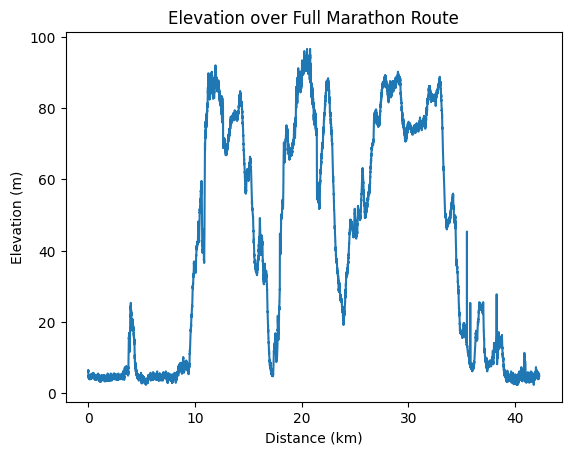

In [60]:
# Replace obvious outlier with interpolation
tcx_df.loc[tcx_df['elevation'] > 100, 'elevation'] = None
tcx_df['elevation'] = tcx_df['elevation'].interpolate()

plt.plot(tcx_df['distance_km'], tcx_df['elevation'])
plt.title('Elevation over Full Marathon Route')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.show()



## 3. Overall Trends

The following graph illustrates my pace and elevation across the 26.2-mile race. 

In [8]:
# create view with pace (min/km)
cur.execute("""
CREATE VIEW IF NOT EXISTS pace_view AS
SELECT
            time,
            latitude,
            longitude,
            elevation,
            distance,
            heart_rate,
            -- compute delta time (sec)
            CAST(
                (strftime('%s', time) - strftime('%s', LAG(time) OVER (ORDER BY time)))
                AS REAL
            ) AS delta_time,
            -- compute delta distance (m)
            (distance - LAG(distance) OVER (ORDER BY time)) AS delta_dist,
            -- compute pace (min/km)
            CAST(
                (strftime('%s', time) - strftime('%s', LAG(time) OVER (ORDER BY time))) / 60.0 /
                NULLIF((distance - LAG(distance) OVER (ORDER BY time)) / 1000.0, 0)
                AS REAL
            ) AS pace
FROM tcx_data
""")

In [20]:
overall_trend_query = """
SELECT distance / 1000.0 AS distance_km, pace, elevation
FROM pace_view
ORDER BY distance
"""
df = pd.read_sql_query(overall_trend_query, con)

def format_pace(pace):
    if pace is None or np.isnan(pace):
        return None
    minutes = int(pace)
    seconds = int(round((pace - minutes) * 60))
    return f"{minutes}:{seconds:02d}"

df['pace_str'] = df['pace'].apply(format_pace)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['distance_km'],
    y=df['pace'],
    mode='lines',
    name='Pace (min/km)',
    line=dict(color='blue'),
    customdata=df['pace_str'],  # attach formatted pace
    hovertemplate='Distance: %{x:.2f} km<br>Pace: %{customdata} min/km<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df['distance_km'],
    y=df['elevation'],
    mode='lines',
    name='Elevation (m)',
    line=dict(color='red'),
    yaxis='y2',
    hovertemplate='Distance: %{x:.2f} km<br>Elevation: %{y} m<extra></extra>'
))

fig.update_layout(
    title='Pace and Elevation over Distance',
    xaxis_title='Distance (km)',
    yaxis=dict(title='Pace (min/km)', side='left'),
    yaxis2=dict(title='Elevation (m)', overlaying='y', side='right')
)

fig.show()




## . Heart Rate vs Pace Analyis

## . Time Losses at Events

## . Heatmap

In [44]:
con.commit()
con.close()


## . Conclusions